In [1]:
!pip -q install pandas numpy scikit-learn imbalanced-learn matplotlib lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.2 MB/s eta 0:00:00


In [2]:
import io, os, sys, pandas as pd, numpy as np, requests, textwrap
from pathlib import Path

DATA_NAME = "paad_clinical.csv"  # we'll save a normalized CSV to this name

print("Please upload your clinical file (CSV/TSV) now")
from google.colab import files
up = files.upload()
assert len(up) == 1, "Upload exactly one file"
fname = list(up.keys())[0]
# auto-detect delimiter
sep = "\t" if fname.lower().endswith((".tsv",".tab")) else ","
df_raw = pd.read_csv(io.BytesIO(up[fname]), sep=sep)

print("Loaded shape:", df_raw.shape)
df_raw.head(3)


Please upload your clinical file (CSV/TSV) now


Saving paad_clinical.csv to paad_clinical.csv
Loaded shape: (184, 63)


,study_id,patient_id,sample_id,diagnosis_age,neoplasm_disease_stage_american_joint_committee_on_cancer_code,american_joint_committee_on_cancer_publication_version_type,aneuploidy_score,buffa_hypoxia_score,cancer_type,tcga_pancanatlas_cancer_type_acronym,...,tumor_break_load,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site,tissue_source_site_code,tmb_nonsynonymous,tumor_disease_anatomic_site,tumor_type,patient_weight,winter_hypoxia_score
0,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB1,TCGA-2J-AAB1-01,65,STAGE IIB,7TH,2.0,-25.0,Pancreatic Cancer,PAAD,...,13.0,No,Yes,Mayo Clinic,2J,2.066667,Pancreas,"Pancreas Adenocarcinoma, Other Subtype",NaN,-24.0
1,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB4,TCGA-2J-AAB4-01,48,STAGE IIB,7TH,6.0,1.0,Pancreatic Cancer,PAAD,...,39.0,No,Yes,Mayo Clinic,2J,0.933333,Pancreas,"Pancreas Adenocarcinoma, Other Subtype",NaN,0.0
2,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB6,TCGA-2J-AAB6-01,75,STAGE IIA,7TH,13.0,23.0,Pancreatic Cancer,PAAD,...,84.0,No,Yes,Mayo Clinic,2J,1.966667,Pancreas,"Pancreas Adenocarcinoma, Ductal Type",NaN,48.0


In [3]:
import re, pandas as pd
from pathlib import Path

def to_snake(name: str) -> str:
    name = re.sub(r"[\(\)\[\]\{\}]+", "", name)
    name = re.sub(r"[^\w]+", "_", name)
    name = re.sub(r"__+", "_", name)
    name = name.strip("_").lower()
    return name

df = df_raw.copy()
df.columns = [to_snake(c) for c in df.columns]

# Heuristics to detect OS time & status columns
time_cands = [c for c in df.columns if "overall_survival_months" in c or (c.endswith("_months") and "disease" not in c)]
status_cands = [c for c in df.columns if "overall_survival_status" in c or (c.endswith("_status") and "tumor" not in c and "ajcc" not in c)]

print("Candidate survival-time columns:", time_cands[:10])
print("Candidate survival-status columns:", status_cands[:10])

# Save normalized CSV for downstream steps
df.to_csv(DATA_NAME, index=False)
print(f"Saved normalized data -> {DATA_NAME}")
df.head(5)


Candidate survival-time columns: ['overall_survival_months', 'progress_free_survival_months']
Candidate survival-status columns: ['disease_free_status', 'disease_specific_survival_status', 'overall_survival_status', 'person_neoplasm_cancer_status', 'progression_free_status', 'somatic_status']
Saved normalized data -> paad_clinical.csv


,study_id,patient_id,sample_id,diagnosis_age,neoplasm_disease_stage_american_joint_committee_on_cancer_code,american_joint_committee_on_cancer_publication_version_type,aneuploidy_score,buffa_hypoxia_score,cancer_type,tcga_pancanatlas_cancer_type_acronym,...,tumor_break_load,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site,tissue_source_site_code,tmb_nonsynonymous,tumor_disease_anatomic_site,tumor_type,patient_weight,winter_hypoxia_score
0,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB1,TCGA-2J-AAB1-01,65,STAGE IIB,7TH,2.0,-25.0,Pancreatic Cancer,PAAD,...,13.0,No,Yes,Mayo Clinic,2J,2.066667,Pancreas,"Pancreas Adenocarcinoma, Other Subtype",NaN,-24.0
1,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB4,TCGA-2J-AAB4-01,48,STAGE IIB,7TH,6.0,1.0,Pancreatic Cancer,PAAD,...,39.0,No,Yes,Mayo Clinic,2J,0.933333,Pancreas,"Pancreas Adenocarcinoma, Other Subtype",NaN,0.0
2,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB6,TCGA-2J-AAB6-01,75,STAGE IIA,7TH,13.0,23.0,Pancreatic Cancer,PAAD,...,84.0,No,Yes,Mayo Clinic,2J,1.966667,Pancreas,"Pancreas Adenocarcinoma, Ductal Type",NaN,48.0
3,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB8,TCGA-2J-AAB8-01,71,STAGE IIB,7TH,9.0,-23.0,Pancreatic Cancer,PAAD,...,60.0,No,Yes,Mayo Clinic,2J,1.433333,Pancreas,"Pancreas Adenocarcinoma, Ductal Type",NaN,-6.0
4,paad_tcga_pan_can_atlas_2018,TCGA-2J-AAB9,TCGA-2J-AAB9-01,70,STAGE IIB,7TH,0.0,-27.0,Pancreatic Cancer,PAAD,...,24.0,No,Yes,Mayo Clinic,2J,0.433333,Pancreas,"Pancreas Adenocarcinoma, Ductal Type",NaN,-16.0


/tmp/ipython-input-3865096686.py:88: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  disc_numeric_cols = [c for c in numeric_cols if (pd.api.types.is_integer_dtype(df_disc[c]) or pd.api.types.is_categorical_dtype(df_disc[c]))]


,threshold_months,n_samples,balanced_accuracy,confusion_matrix
4,24,126,0.630682,"[[19, 19], [21, 67]]"
0,9,170,0.607337,"[[90, 48], [14, 18]]"
3,18,139,0.560352,"[[31, 38], [23, 47]]"
2,15,150,0.539876,"[[48, 49], [22, 31]]"
1,12,161,0.482558,"[[59, 59], [23, 20]]"


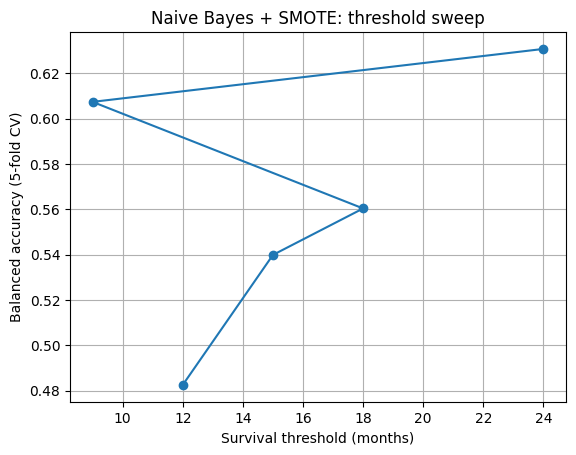

Best threshold T* = 24 months | Balanced accuracy = 0.631 | n = 126


,y_true,y_pred
0,1,1
2,1,0
4,1,1
5,1,1
7,1,1
8,0,0
9,0,0
15,1,1
16,1,1
17,1,1


In [4]:


import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import CategoricalNB

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ---- helper to build a dense OneHotEncoder across sklearn versions ----
def make_ohe():
    try:
        # new sklearn (>=1.2) supports sparse_output
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # older sklearn uses 'sparse'
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# ---------- Load normalized file from Step 1 ----------
df = pd.read_csv("paad_clinical.csv")

# ---------- Detect survival columns ----------
time_col_candidates = [c for c in df.columns if "overall_survival_months" in c or (c.endswith("_months") and "disease" not in c)]
status_col_candidates = [c for c in df.columns if "overall_survival_status" in c or (c.endswith("_status") and "tumor" not in c and "ajcc" not in c)]

time_col = "overall_survival_months" if "overall_survival_months" in df.columns else (time_col_candidates[0] if time_col_candidates else None)
status_col = "overall_survival_status" if "overall_survival_status" in df.columns else (status_col_candidates[0] if status_col_candidates else None)
assert time_col is not None and status_col is not None, "Could not auto-detect survival columns."

df[time_col] = pd.to_numeric(df[time_col], errors="coerce")

def status_to_event(x: str) -> float:
    if not isinstance(x, str): return np.nan
    s = x.strip().lower()
    if "deceased" in s or "dead" in s or s in {"1","1:deceased","deceased:1"}: return 1.0
    if "living" in s or "alive" in s or s in {"0","0:living","living:0"}:   return 0.0
    if "died" in s:       return 1.0
    if "censored" in s:   return 0.0
    return np.nan

df["event"] = df[status_col].apply(status_to_event)

# ---------- Build candidate feature set (clinical) ----------
exclude_patterns = [
    r"^patient", r"^sample", r"^case", r"^tumor_sample", r"^aliquot", r"^barcode",
    r"_status$", r"_months$", r"^os_", r"^progress", r"^disease_", r"^months_of_", r"^days_",
    r"^form_completion_date", r"^last_", r"^birth_", r"_date$", r"_day_value$",
    r"^cancer_type", r"^tcga_", r"^pan$", r"^project_"
]
def keep_col(c):
    for p in exclude_patterns:
        if re.search(p, c): return False
    return True

candidate_cols = [c for c in df.columns if keep_col(c) and c not in {time_col, status_col, "event"}]

# Split numeric vs categorical (heuristic)
numeric_cols, categorical_cols = [], []
for c in candidate_cols:
    try_num = pd.to_numeric(df[c], errors="coerce")
    ratio_num = try_num.notna().mean()
    (numeric_cols if ratio_num > 0.8 else categorical_cols).append(c)

# Include useful categoricals if somehow missed
for hint in ["sex","gender","tumor_stage","ajcc_pathologic_stage","ajcc_clinical_stage","grade","neoplasm_disease_stage"]:
    if hint in df.columns and hint not in categorical_cols and hint not in numeric_cols:
        categorical_cols.append(hint)

# ---------- Discretize numeric (quantile bins) and treat all as categorical ----------
def discretize_numeric(df_in, cols, n_bins=3):
    out = df_in.copy()
    for c in cols:
        series = pd.to_numeric(out[c], errors="coerce")
        if series.notna().sum() < 10 or series.nunique(dropna=True) < 5:
            continue
        try:
            out[c] = pd.qcut(series.rank(method="average"), q=n_bins, labels=False, duplicates="drop")
        except Exception:
            out[c] = pd.cut(series, bins=n_bins, labels=False, duplicates="drop")
    return out

df_disc = discretize_numeric(df, numeric_cols, n_bins=3)
disc_numeric_cols = [c for c in numeric_cols if (pd.api.types.is_integer_dtype(df_disc[c]) or pd.api.types.is_categorical_dtype(df_disc[c]))]
all_feature_cols = sorted(set(disc_numeric_cols + categorical_cols))

pre_all_cat = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", make_ohe())   # version-safe dense encoder
        ]), all_feature_cols)
    ]
)

# ---------- Threshold sweep ----------
threshold_grid = [9, 12, 15, 18, 24]  # months
results = []
best = None

for T in threshold_grid:
    mask_valid = df_disc[time_col].notna() & df_disc["event"].notna()
    df_T = df_disc.loc[mask_valid].copy()
    y = np.where((df_T["event"] == 1.0) & (df_T[time_col] < T), 1, np.where(df_T[time_col] >= T, 0, -1))
    keep = y != -1
    df_T = df_T.loc[keep]
    y = y[keep]

    # need both classes and enough samples
    if len(np.unique(y)) < 2 or df_T.shape[0] < 40:
        continue

    X = df_T[all_feature_cols].copy()

    clf = ImbPipeline(steps=[
        ("prep", pre_all_cat),
        ("smote", SMOTE(random_state=42, k_neighbors=3)),
        ("nb", CategoricalNB())
    ])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_all, y_true_all = [], []
    for tr, te in skf.split(X, y):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y[tr], y[te]
        clf.fit(X_tr, y_tr)
        yp = clf.predict(X_te)
        y_pred_all.extend(yp.tolist())
        y_true_all.extend(y_te.tolist())

    bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    results.append({"threshold_months": T, "n_samples": int(X.shape[0]), "balanced_accuracy": bal_acc, "confusion_matrix": cm.tolist()})

    if best is None or bal_acc > best["balanced_accuracy"]:
        best = {"T": T, "balanced_accuracy": bal_acc, "n": int(X.shape[0]), "pipeline": clf, "X": X, "y": y}

if not results:
    raise RuntimeError("No usable thresholds produced both classes. Try different thresholds or verify survival columns.")

res_df = pd.DataFrame(results).sort_values("balanced_accuracy", ascending=False)
display(res_df)

# Plot
plt.figure()
plt.plot(res_df["threshold_months"], res_df["balanced_accuracy"], marker="o")
plt.xlabel("Survival threshold (months)")
plt.ylabel("Balanced accuracy (5-fold CV)")
plt.title("Naive Bayes + SMOTE: threshold sweep")
plt.grid(True)
plt.show()

print(f"Best threshold T* = {best['T']} months | Balanced accuracy = {best['balanced_accuracy']:.3f} | n = {best['n']}")

# Fit best model on all labeled data at T*
clf_best = best["pipeline"]
X_best = best["X"]
y_best = best["y"]
clf_best.fit(X_best, y_best)
y_hat = clf_best.predict(X_best)

pred_out = pd.DataFrame({"y_true": y_best, "y_pred": y_hat}, index=X_best.index).sort_index()
pred_out.head(10)


/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column neoplasm_disease_stage_american_joint_committee_on_cancer_code_nan have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'neoplasm_disease_stage_american_joint_committee_on_cancer_code_nan'].var())
>>> print(df.loc[~events, 'neoplasm_disease_stage_american_joint_committee_on_cancer_code_nan'].var())

A very low variance means that the column neoplasm_disease_stage_american_joint_committee_on_cancer_code_nan completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1163: Co

Final feature count after screening: 20 (kept top 20 by univariate p-value)


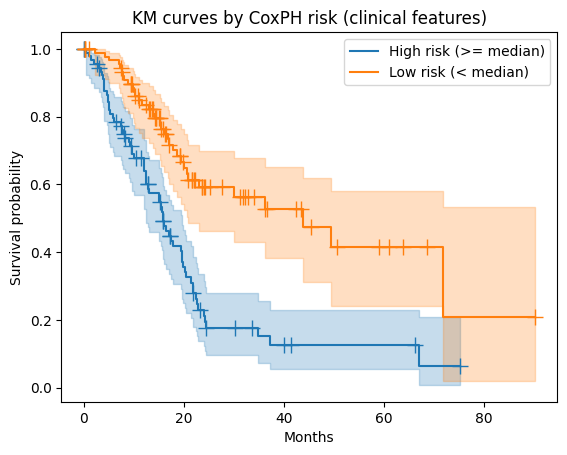

Samples used: 184
Features in final Cox model: 20
5-fold CV C-index: 0.644 ± 0.115
Log-rank p-value (high vs low risk): 1.401e-06
Wrote: outputs_step3/coxph_clinical_summary.csv
Wrote: outputs_step3/km_clinical_median_risk.png
Wrote: outputs_step3/step3_cox_report.txt


In [5]:


!pip -q install lifelines

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

DATA_NAME = "paad_clinical.csv"
assert Path(DATA_NAME).exists(), f"{DATA_NAME} not found. Run Cells 1–3 first."
df0 = pd.read_csv(DATA_NAME)

# ---------- detect survival columns ----------
time_cands = [c for c in df0.columns if "overall_survival_months" in c or (c.endswith("_months") and "disease" not in c)]
status_cands = [c for c in df0.columns if "overall_survival_status"  in c or (c.endswith("_status") and "tumor" not in c and "ajcc" not in c)]
time_col   = "overall_survival_months" if "overall_survival_months" in df0.columns else (time_cands[0] if time_cands else None)
status_col = "overall_survival_status"  if "overall_survival_status"  in df0.columns else (status_cands[0] if status_cands else None)
assert time_col is not None and status_col is not None, "Could not auto-detect survival columns."

df0[time_col] = pd.to_numeric(df0[time_col], errors="coerce")

def status_to_event(x: str) -> float:
    if not isinstance(x, str): return np.nan
    s = x.strip().lower()
    if "deceased" in s or "dead" in s or s in {"1","1:deceased","deceased:1"}: return 1.0
    if "living" in s or "alive"  in s or s in {"0","0:living","living:0"}:   return 0.0
    if "died" in s:     return 1.0
    if "censored" in s: return 0.0
    return np.nan

df0["event"] = df0[status_col].apply(status_to_event)

# ---------- feature pre-filter ----------
drop_like = [
    r"^patient", r"^sample", r"^case", r"^tumor_sample", r"^aliquot", r"^barcode",
    r"^other_patient_id", r"tissue_source_site", r"_code_", r"icd", r"^days_", r"_date$", r"_day_value$",
    r"_status$", r"_months$", r"^os_", r"^progress", r"^disease_", r"^months_of_",
    r"^form_completion_date", r"^last_", r"^birth_", r"^cancer_type", r"^tcga_", r"^pan$", r"^project_"
]
def drop_col(c):
    for p in drop_like:
        if re.search(p, c): return True
    return False

cand = [c for c in df0.columns if c not in {time_col, status_col, "event"} and not drop_col(c)]

# split numeric vs categorical
num_cols, cat_cols = [], []
for c in cand:
    s = pd.to_numeric(df0[c], errors="coerce")
    if s.notna().mean() > 0.8 and s.nunique(dropna=True) >= 5:
        num_cols.append(c)
    else:
        cat_cols.append(c)

# cap categorical cardinality
cat_cols = [c for c in cat_cols if df0[c].astype(str).nunique(dropna=True) <= 20]

# standard clinical categoricals if present
for hint in ["sex","gender","tumor_stage","ajcc_pathologic_stage","ajcc_clinical_stage","grade","neoplasm_disease_stage"]:
    if hint in df0.columns and hint not in cat_cols and hint not in num_cols:
        cat_cols.append(hint)

# ---------- impute & one-hot ----------
df = df0[[time_col, "event"] + num_cols + cat_cols].copy()

for c in num_cols:
    s = pd.to_numeric(df[c], errors="coerce")
    df[c] = s.fillna(s.median())

for c in cat_cols:
    m = df[c].mode(dropna=True)
    fill = m.iloc[0] if len(m) else "missing"
    df[c] = df[c].astype(str).fillna(fill)

X = pd.get_dummies(df[num_cols + cat_cols], drop_first=True)
y_time  = df[time_col].astype(float)
y_event = df["event"].astype(float)

mask = y_time.notna() & y_event.notna()
X = X.loc[mask].copy()
y_time = y_time.loc[mask].copy()
y_event = y_event.loc[mask].copy()

# drop zero-variance
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    X = X.drop(columns=const_cols)

# drop highly collinear (|corr| > 0.95)
if X.shape[1] > 1:
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if (upper[col] > 0.95).any()]
    if to_drop:
        X = X.drop(columns=to_drop)

# ---------- univariate Cox screening ----------
K = min(20, max(8, X.shape[0] // 6))
pvals = []
cph_uni = CoxPHFitter(penalizer=0.0)
for c in X.columns:
    try:
        df_uni = pd.DataFrame({"T": y_time, "E": y_event, c: X[c]})
        cph_uni.fit(df_uni, duration_col="T", event_col="E")
        p = float(cph_uni.summary.loc[c, "p"])
    except Exception:
        p = 1.0
    pvals.append((c, p))
pvals.sort(key=lambda x: x[1])
keep_cols = [c for c, _ in pvals[:K]]
X = X[keep_cols].copy()

print(f"Final feature count after screening: {X.shape[1]} (kept top {K} by univariate p-value)")

# ---------- full Cox model (elastic-net) ----------
cph = CoxPHFitter(penalizer=0.5, l1_ratio=0.2)
df_fit = pd.concat([X, y_time.rename("T"), y_event.rename("E")], axis=1)
cph.fit(df_fit, duration_col="T", event_col="E")

outdir = Path("outputs_step3"); outdir.mkdir(parents=True, exist_ok=True)
coef_path = outdir / "coxph_clinical_summary.csv"
cph.summary.reset_index().rename(columns={"index": "feature"}).to_csv(coef_path, index=False)

# ---------- 5-fold CV C-index (FIXED risk extraction) ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindex_scores = []
for tr, te in kf.split(X):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    T_tr, T_te = y_time.iloc[tr], y_time.iloc[te]
    E_tr, E_te = y_event.iloc[tr], y_event.iloc[te]
    cph_cv = CoxPHFitter(penalizer=0.5, l1_ratio=0.2)
    cph_cv.fit(pd.concat([X_tr, T_tr.rename("T"), E_tr.rename("E")], axis=1), duration_col="T", event_col="E")
    # Treat output as 1D regardless of lifelines version
    risk_te = np.asarray(cph_cv.predict_partial_hazard(X_te)).ravel()
    cindex = concordance_index(T_te, -risk_te, E_te)
    cindex_scores.append(cindex)

cindex_mean = float(np.mean(cindex_scores))
cindex_std  = float(np.std(cindex_scores, ddof=1))

# ---------- KM split by median risk (FIXED risk extraction) ----------
risk_all = np.asarray(cph.predict_partial_hazard(X)).ravel()
med = float(np.median(risk_all))
hi = risk_all >= med
lo = risk_all <  med

km_hi = KaplanMeierFitter(); km_lo = KaplanMeierFitter()
plt.figure()
km_hi.fit(y_time[hi], event_observed=y_event[hi], label="High risk (>= median)")
ax = km_hi.plot(show_censors=True)
km_lo.fit(y_time[lo], event_observed=y_event[lo], label="Low risk (< median)")
km_lo.plot(ax=ax, show_censors=True)
plt.xlabel("Months"); plt.ylabel("Survival probability")
plt.title("KM curves by CoxPH risk (clinical features)")
km_path = outdir / "km_clinical_median_risk.png"
plt.savefig(km_path, bbox_inches="tight"); plt.show()

# ---------- log-rank ----------
lr = logrank_test(y_time[hi], y_time[lo],
                  event_observed_A=y_event[hi],
                  event_observed_B=y_event[lo])
logrank_p = float(lr.p_value)

# ---------- report ----------
report = [
    f"Samples used: {X.shape[0]}",
    f"Features in final Cox model: {X.shape[1]}",
    f"5-fold CV C-index: {cindex_mean:.3f} ± {cindex_std:.3f}",
    f"Log-rank p-value (high vs low risk): {logrank_p:.3e}"
]
report_text = "\n".join(report)
(Path(outdir) / "step3_cox_report.txt").write_text(report_text)

print(report_text)
print("Wrote:", coef_path)
print("Wrote:", km_path)
print("Wrote:", Path(outdir) / "step3_cox_report.txt")


In [7]:
# for downloading all outputs/results
import os, io, re, json, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import CategoricalNB
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

from google.colab import files

DATA_NAME = "paad_clinical.csv"
assert Path(DATA_NAME).exists(), f"{DATA_NAME} not found. Run Cells 1–3 (and 5 for Cox) first."

# ---------- Helpers ----------
def make_ohe():
    # version-safe dense OneHotEncoder
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def status_to_event(x: str) -> float:
    if not isinstance(x, str): return np.nan
    s = x.strip().lower()
    if "deceased" in s or "dead" in s or s in {"1","1:deceased","deceased:1"}: return 1.0
    if "living" in s or "alive"  in s or s in {"0","0:living","living:0"}:   return 0.0
    if "died" in s:     return 1.0
    if "censored" in s: return 0.0
    return np.nan

def discretize_numeric(df_in, cols, n_bins=3):
    out = df_in.copy()
    for c in cols:
        series = pd.to_numeric(out[c], errors="coerce")
        if series.notna().sum() < 10 or series.nunique(dropna=True) < 5:
            continue
        try:
            out[c] = pd.qcut(series.rank(method="average"), q=n_bins, labels=False, duplicates="drop")
        except Exception:
            out[c] = pd.cut(series, bins=n_bins, labels=False, duplicates="drop")
    return out

# ---------- Load + detect survival columns ----------
df = pd.read_csv(DATA_NAME)

time_cands   = [c for c in df.columns if "overall_survival_months" in c or (c.endswith("_months") and "disease" not in c)]
status_cands = [c for c in df.columns if "overall_survival_status"  in c or (c.endswith("_status") and "tumor" not in c and "ajcc" not in c)]
time_col   = "overall_survival_months" if "overall_survival_months" in df.columns else (time_cands[0] if time_cands else None)
status_col = "overall_survival_status"  if "overall_survival_status"  in df.columns else (status_cands[0] if status_cands else None)
assert time_col is not None and status_col is not None, "Could not auto-detect survival columns."

df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
df["event"]  = df[status_col].apply(status_to_event)

# ---------- Build candidate feature set (clinical) ----------
exclude_patterns = [
    r"^patient", r"^sample", r"^case", r"^tumor_sample", r"^aliquot", r"^barcode",
    r"_status$", r"_months$", r"^os_", r"^progress", r"^disease_", r"^months_of_", r"^days_",
    r"^form_completion_date", r"^last_", r"^birth_", r"_date$", r"_day_value$",
    r"^cancer_type", r"^tcga_", r"^pan$", r"^project_"
]
def keep_col(c):
    for p in exclude_patterns:
        if re.search(p, c): return False
    return True

candidate_cols = [c for c in df.columns if keep_col(c) and c not in {time_col, status_col, "event"}]

numeric_cols, categorical_cols = [], []
for c in candidate_cols:
    try_num = pd.to_numeric(df[c], errors="coerce")
    ratio_num = try_num.notna().mean()
    (numeric_cols if ratio_num > 0.8 else categorical_cols).append(c)

for hint in ["sex","gender","tumor_stage","ajcc_pathologic_stage","ajcc_clinical_stage","grade","neoplasm_disease_stage"]:
    if hint in df.columns and hint not in categorical_cols and hint not in numeric_cols:
        categorical_cols.append(hint)

# ---------- Step 2 re-run (save artifacts) ----------
df_disc = discretize_numeric(df, numeric_cols, n_bins=3)
disc_numeric_cols = [c for c in numeric_cols if (pd.api.types.is_integer_dtype(df_disc[c]) or pd.api.types.is_categorical_dtype(df_disc[c]))]
all_feature_cols = sorted(set(disc_numeric_cols + categorical_cols))

pre_all_cat = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", make_ohe())
        ]), all_feature_cols)
    ]
)

threshold_grid = [9, 12, 15, 18, 24]
results = []
best = None

for T in threshold_grid:
    mask_valid = df_disc[time_col].notna() & df_disc["event"].notna()
    df_T = df_disc.loc[mask_valid].copy()
    y = np.where((df_T["event"] == 1.0) & (df_T[time_col] < T), 1, np.where(df_T[time_col] >= T, 0, -1))
    keep = y != -1
    df_T = df_T.loc[keep]
    y = y[keep]
    if len(np.unique(y)) < 2 or df_T.shape[0] < 40:
        continue

    X = df_T[all_feature_cols].copy()

    clf = ImbPipeline(steps=[
        ("prep", pre_all_cat),
        ("smote", SMOTE(random_state=42, k_neighbors=3)),
        ("nb", CategoricalNB())
    ])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_all, y_true_all = [], []
    for tr, te in skf.split(X, y):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y[tr], y[te]
        clf.fit(X_tr, y_tr)
        yp = clf.predict(X_te)
        y_pred_all.extend(yp.tolist())
        y_true_all.extend(y_te.tolist())

    bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    results.append({"threshold_months": T, "n_samples": int(X.shape[0]), "balanced_accuracy": bal_acc, "confusion_matrix": cm.tolist()})

    if best is None or bal_acc > best["balanced_accuracy"]:
        best = {"T": T, "balanced_accuracy": bal_acc, "n": int(X.shape[0]), "pipeline": clf, "X": X, "y": y}

# Save Step 2 table
os.makedirs("outputs_step2", exist_ok=True)
res_df = pd.DataFrame(results).sort_values("balanced_accuracy", ascending=False)
res_df.to_csv("outputs_step2/nb_threshold_sweep_results.csv", index=False)

# Plot Step 2 curve
plt.figure()
plt.plot(res_df["threshold_months"], res_df["balanced_accuracy"], marker="o")
plt.xlabel("Survival threshold (months)")
plt.ylabel("Balanced accuracy (5-fold CV)")
plt.title("Naive Bayes + SMOTE: threshold sweep")
plt.grid(True)
plt.savefig("outputs_step2/nb_threshold_sweep_balacc.png", bbox_inches="tight"); plt.close()

# Fit best and save predictions
clf_best = best["pipeline"]; X_best = best["X"]; y_best = best["y"]
clf_best.fit(X_best, y_best)
y_hat = clf_best.predict(X_best)
pred_df = pd.DataFrame({"y_true": y_best, "y_pred": y_hat}, index=X_best.index).sort_index()
pred_df.to_csv("outputs_step2/nb_predictions_best_threshold.csv")
with open("outputs_step2/step2_summary.txt", "w") as f:
    f.write(f"Best threshold T* = {best['T']} months | Balanced accuracy = {best['balanced_accuracy']:.3f} | n = {best['n']}\n")

print(f"[Step 2] Saved results at outputs_step2/, best T* = {best['T']} months, bal-acc = {best['balanced_accuracy']:.3f}")

# ---------- Gather Step 3 outputs (already produced by Cell 5) ----------
step3_files = [
    "outputs_step3/coxph_clinical_summary.csv",
    "outputs_step3/km_clinical_median_risk.png",
    "outputs_step3/step3_cox_report.txt",
]
missing_step3 = [p for p in step3_files if not Path(p).exists()]
if missing_step3:
    print("WARNING: Some Step 3 outputs are missing. Did you run Cell 5? Missing ->", missing_step3)

# ---------- Zip everything ----------
bundle_path = "outputs_bundle.zip"
with zipfile.ZipFile(bundle_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    # Step 2
    for p in Path("outputs_step2").glob("*"):
        z.write(p, arcname=f"outputs_step2/{p.name}")
    # Step 3 (if present)
    for p in step3_files:
        if Path(p).exists():
            z.write(p, arcname=f"outputs_step3/{Path(p).name}")

print("Bundled:", bundle_path)
files.download(bundle_path)

/tmp/ipython-input-3074563049.py:91: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  disc_numeric_cols = [c for c in numeric_cols if (pd.api.types.is_integer_dtype(df_disc[c]) or pd.api.types.is_categorical_dtype(df_disc[c]))]


[Step 2] Saved results at outputs_step2/, best T* = 24 months, bal-acc = 0.631
Bundled: outputs_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>